In [1]:
import sys
import os
sys.path.append(os.path.abspath("../"))  # or "../../" depending on location
from setup import add_project_root
add_project_root()

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from models.inverse.CNN_inverse_models import CNNInverseClassifier
from models.inverse.FNO_inverse_models import FNOInverseClassifier

from evaluate_inverse_functions import *

import time
import japanize_matplotlib

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [3]:
test_data = torch.load('../data/datasets/data/darcy_test_16.pt')
test_data_32 = torch.load("../data/datasets/data/darcy_test_32.pt")
x_test = test_data["y"].unsqueeze(1).float()
y_test = test_data["x"].unsqueeze(1).float()
x_test_32 = test_data_32["y"].unsqueeze(1).float()
y_test_32 = test_data_32["x"].unsqueeze(1).float()

/var/folders/k3/b1t1gjg12pg0ycfdgpm2k7g00000gn/T/ipykernel_73338/1825119486.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load('../data/datasets/data

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn = CNNInverseClassifier().to(device)
cnn.load_state_dict(torch.load("../results/inverse/checkpoints/best_CNN_inverse_model.pth", map_location=device))
cnn.eval()

fno = FNOInverseClassifier(modes1=8, modes2=8, width=32).to(device)
fno.load_state_dict(torch.load("../results/inverse/checkpoints/best_FNO_inverse_model.pth", map_location=device))
fno.eval()

x_test = x_test.to(device)
y_test = y_test.to(device)

x_test_32 = x_test_32.to(device)
y_test_32 = y_test_32.to(device)

threshold = 0.5 



/var/folders/k3/b1t1gjg12pg0ycfdgpm2k7g00000gn/T/ipykernel_73338/1200739888.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn.load_state_dict(torch.load("../results/in

In [5]:
# --- 実行フェーズ ---
inference_times = {}
metrics = {}
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
with torch.no_grad():

    # CNN
    t_cnn, m_cnn, pred_cnn = measure_inference_and_eval(cnn, x_test, y_test, binarize=True, warmup=10, repeat=100)
    inference_times["CNN"] = t_cnn
    metrics["CNN"] = m_cnn
    print(count_params(cnn))



    # FNO
    x_test_fno = x_test.permute(0, 2, 3, 1)  # (B, H, W, 1)
    t_fno, m_fno,pred_fno = measure_inference_and_eval(fno, x_test_fno, y_test,binarize=True,warmup=10,repeat=100)
    inference_times["FNO"] = t_fno
    metrics["FNO"] = m_fno
    print(count_params(fno))

    y_true = y_test.cpu()  

# --- 結果表示 ---
summary_metrics_table_binary(inference_times,metrics,)


torch.float32 torch.float32
416481
torch.float32 torch.float32
204257
【評価結果：2値分類】

【推論時間（ms）】
CNN            : 26.13 ms
FNO            : 24.12 ms

【評価指標（2値分類）】
Model             Accuracy        IoU       Dice
--------------------------------------------------
CNN                 0.9415     0.8713     0.9187
FNO                 0.9378     0.8604     0.9087


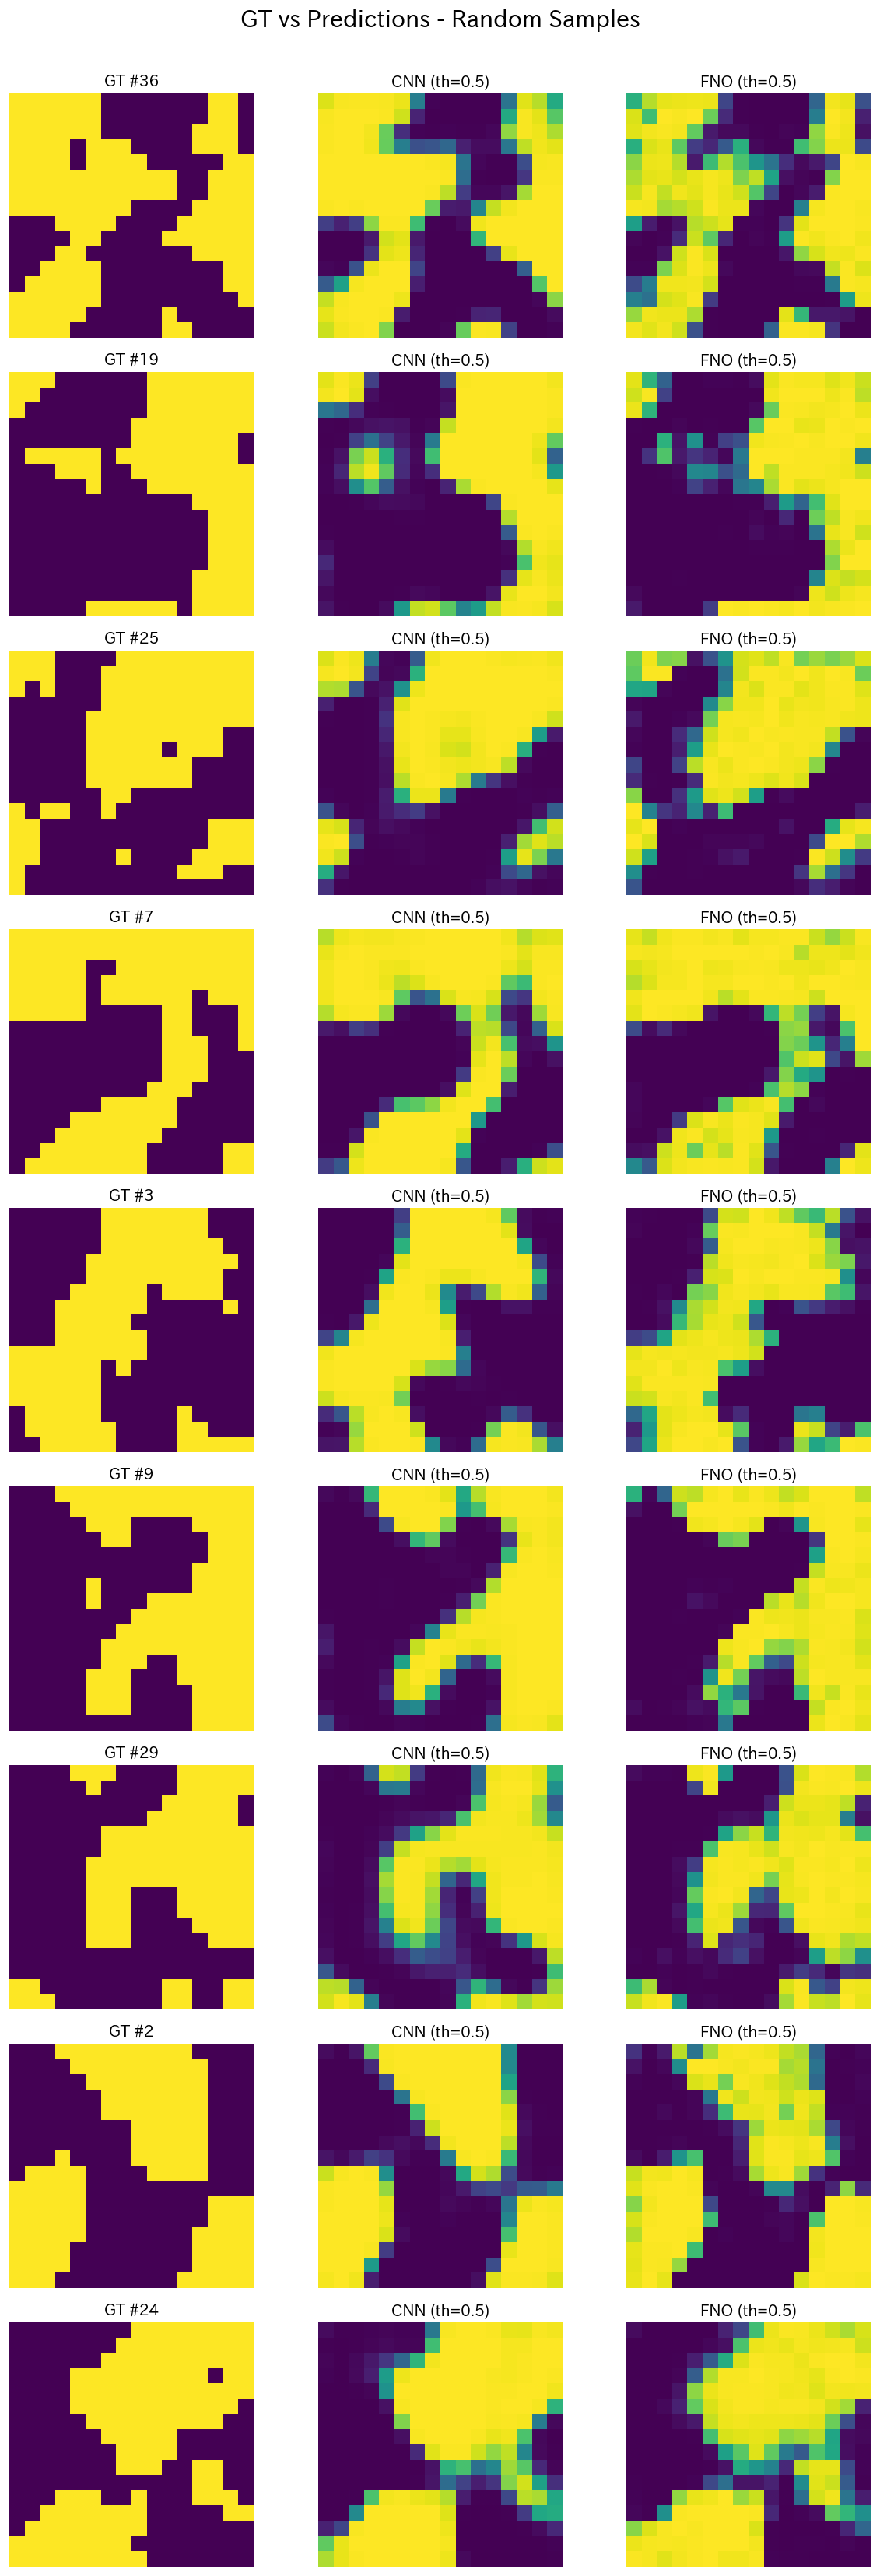

In [6]:
gt_images = y_true.squeeze(1)                    # [B, 1, H, W] → [B, H, W]

cnn_images = pred_cnn.squeeze(1)               # [B, 1, H, W] → [B, H, W]
fno_images = pred_fno.squeeze(-1)  # [B, 1, H, W] → [B, H, W]             

preds = [cnn_images, fno_images]
labels = ["CNN", "FNO"]
plot_random_binary_predictions(gt_images,preds,labels,threshold=threshold)

/Users/yamashitanatsuki/Documents/Python/neural_operator_comparison/notebooks/evaluate_inverse_functions.py:191: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 0.96])


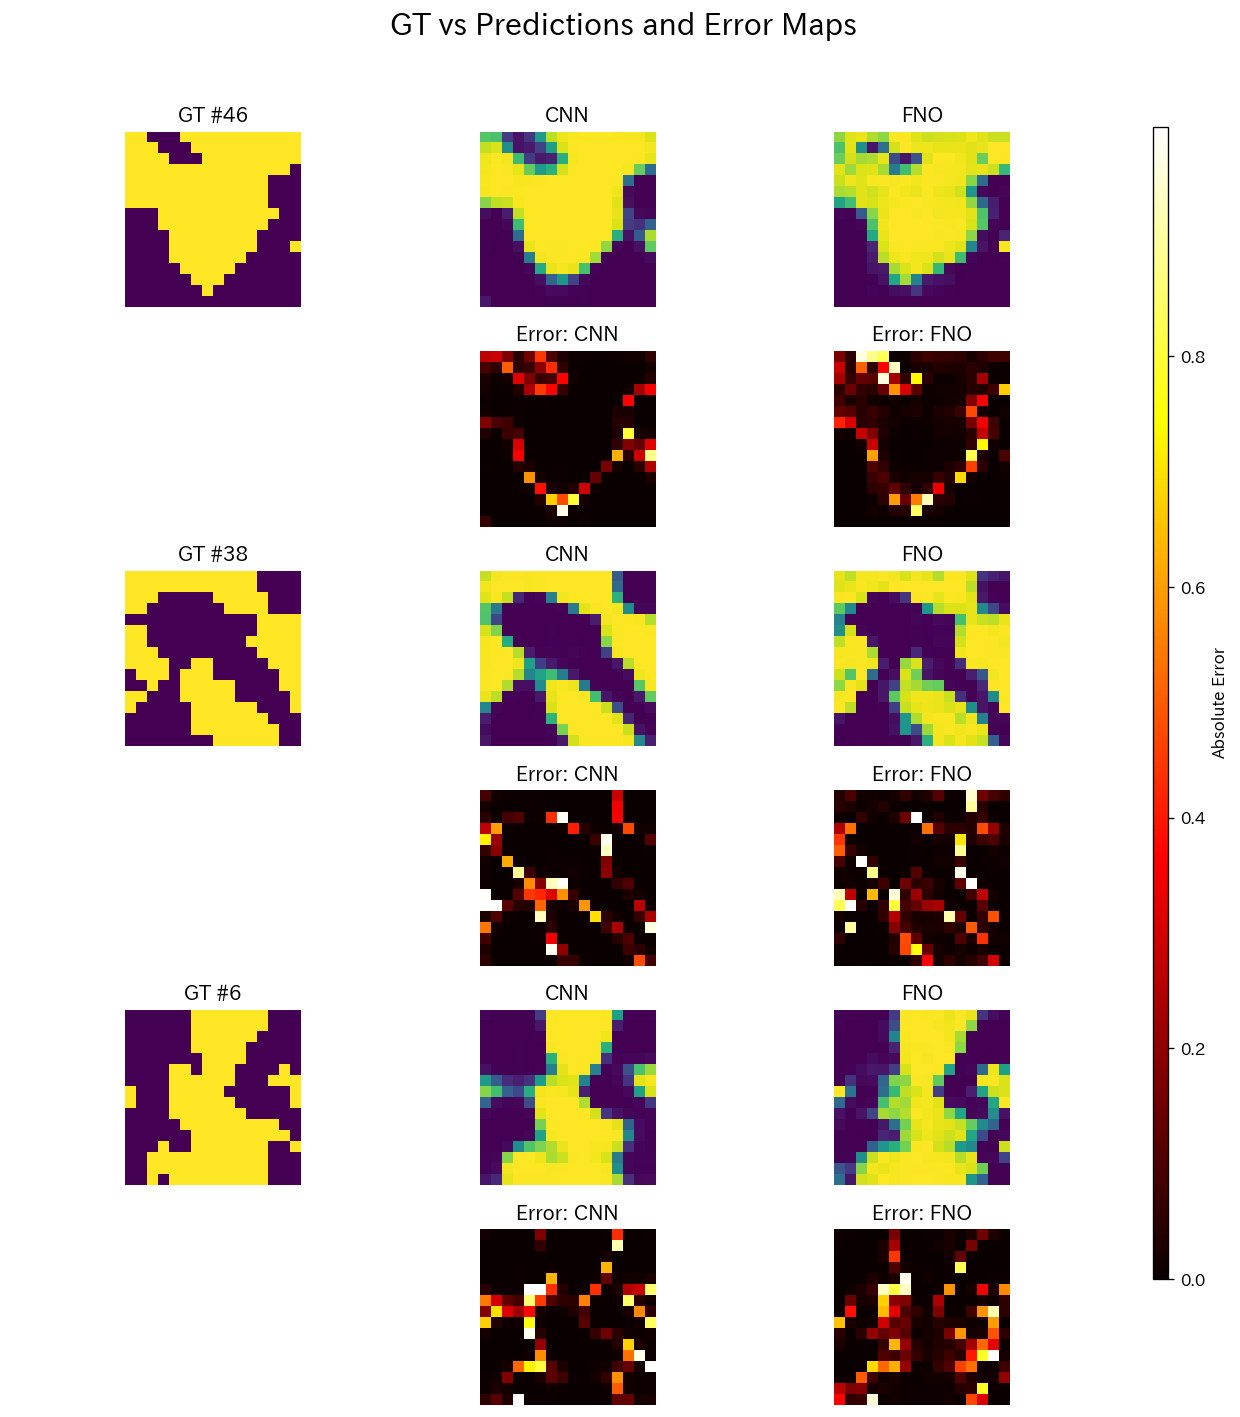

In [7]:
plot_prediction_and_error_maps(gt_images,preds,labels,num_samples=3)

FP: 358, FN: 391


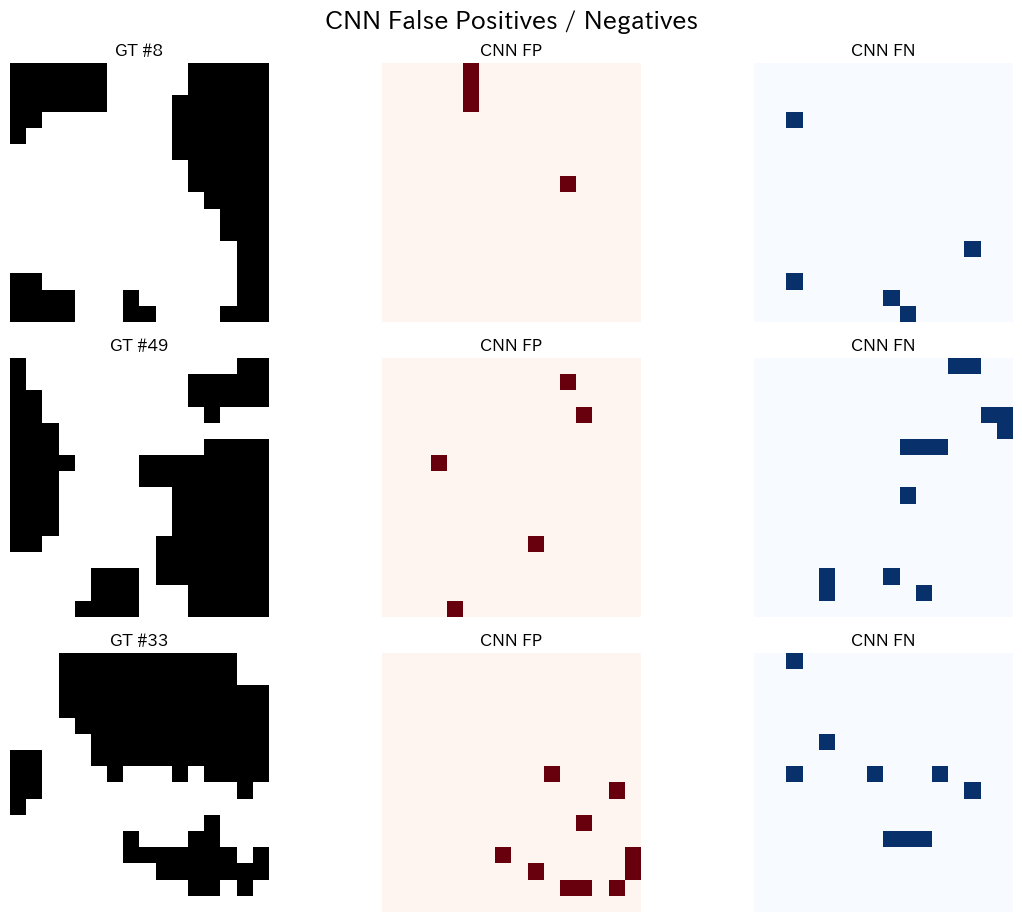

FP: 472, FN: 324


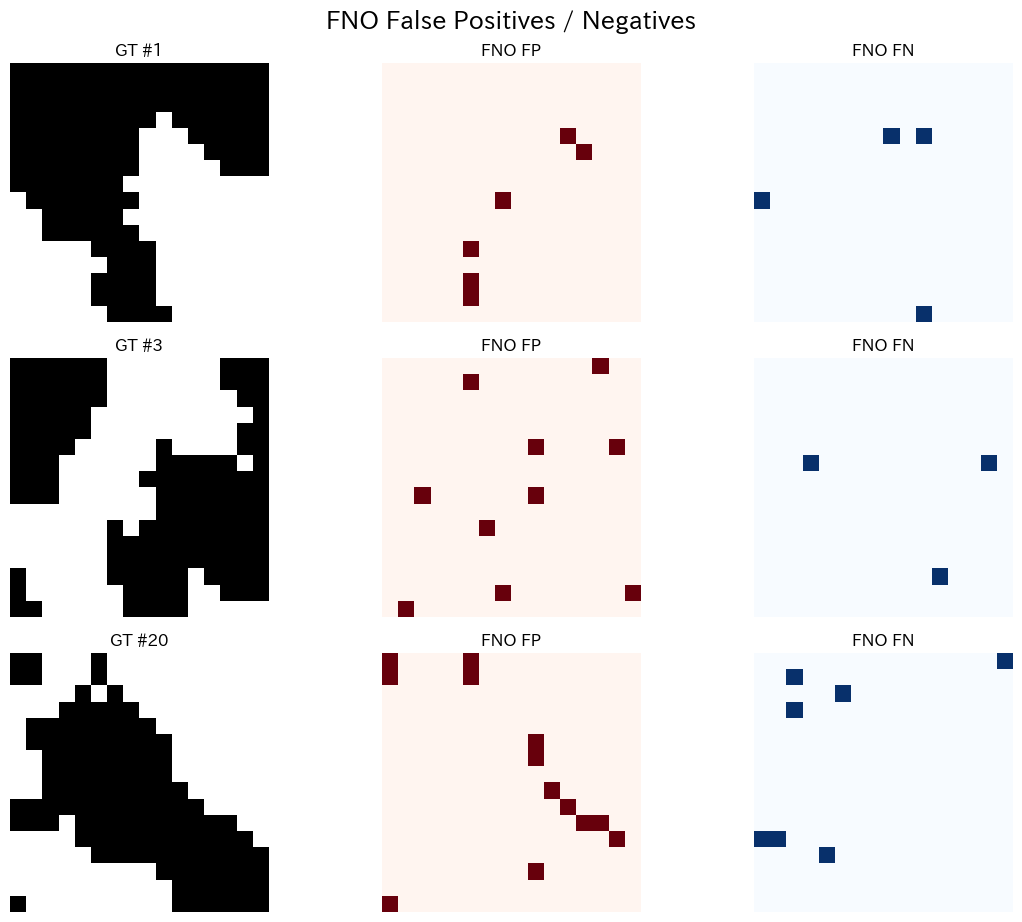

In [8]:

plot_fp_fn_examples(pred_cnn, y_true, model_name="CNN",num_samples=3)
plot_fp_fn_examples(pred_fno, y_true, model_name="FNO",num_samples=3)

In [9]:
inference_times_32 = {}
metrics_32 = {}


with torch.no_grad():

    
    # CNN
    t_cnn_32, m_cnn_32, pred_cnn_32 = measure_inference_and_eval(cnn, x_test_32, y_test_32, warmup=10, repeat=100)
    inference_times_32["CNN"] = t_cnn_32
    metrics_32["CNN"] = m_cnn_32



    # FNO
    x_test_fno_32 = x_test_32.permute(0, 2, 3, 1)
    t_fno_32, m_fno_32, pred_fno_32 = measure_inference_and_eval(fno, x_test_fno_32, y_test_32,  warmup=10, repeat=100)
    inference_times_32["FNO"] = t_fno_32
    metrics_32["FNO"] = m_fno_32

    # 可視化用GT保存
    y_true_32 = y_test_32.cpu()

summary_metrics_table_binary(inference_times_32, metrics_32)

torch.float32 torch.float32
torch.float32 torch.float32
【評価結果：2値分類】

【推論時間（ms）】
CNN            : 84.24 ms
FNO            : 66.16 ms

【評価指標（2値分類）】
Model             Accuracy        IoU       Dice
--------------------------------------------------
CNN                 0.7513     0.6463     0.7541
FNO                 0.9234     0.8332     0.8940


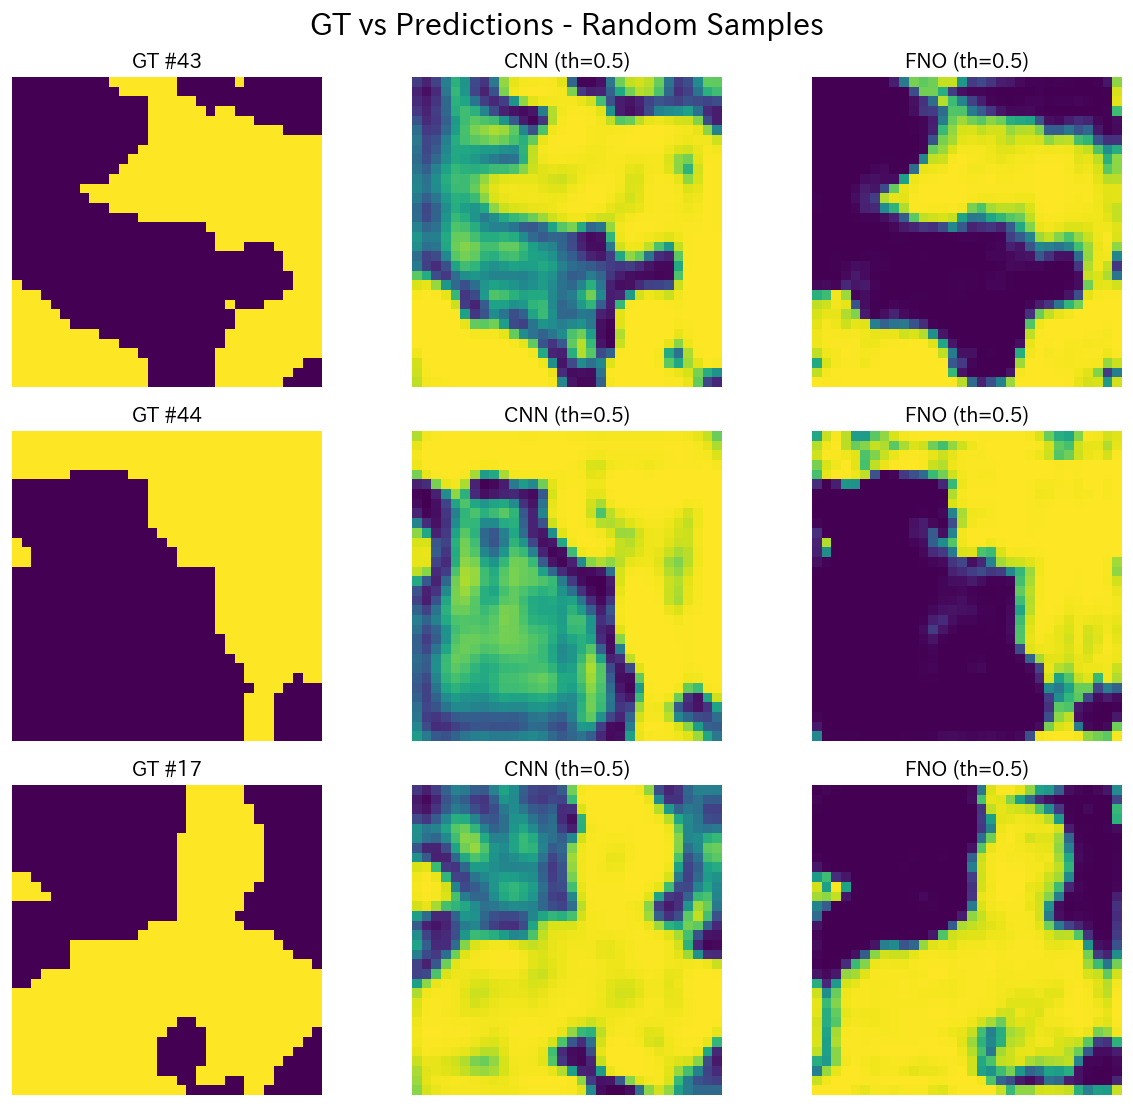

In [10]:
gt_images_32 = y_true_32.squeeze(1)                    # [B, 1, H, W] → [B, H, W]
cnn_images_32 = pred_cnn_32.squeeze(1)               # [B, 1, H, W] → [B, H, W]
fno_images_32 = pred_fno_32.squeeze(-1)                # [B, H, W, 1]

preds_32 = [cnn_images_32, fno_images_32]
labels_32 = ["CNN", "FNO"]

plot_random_binary_predictions(gt_images_32, preds_32,labels_32, threshold=threshold,num_samples=3)


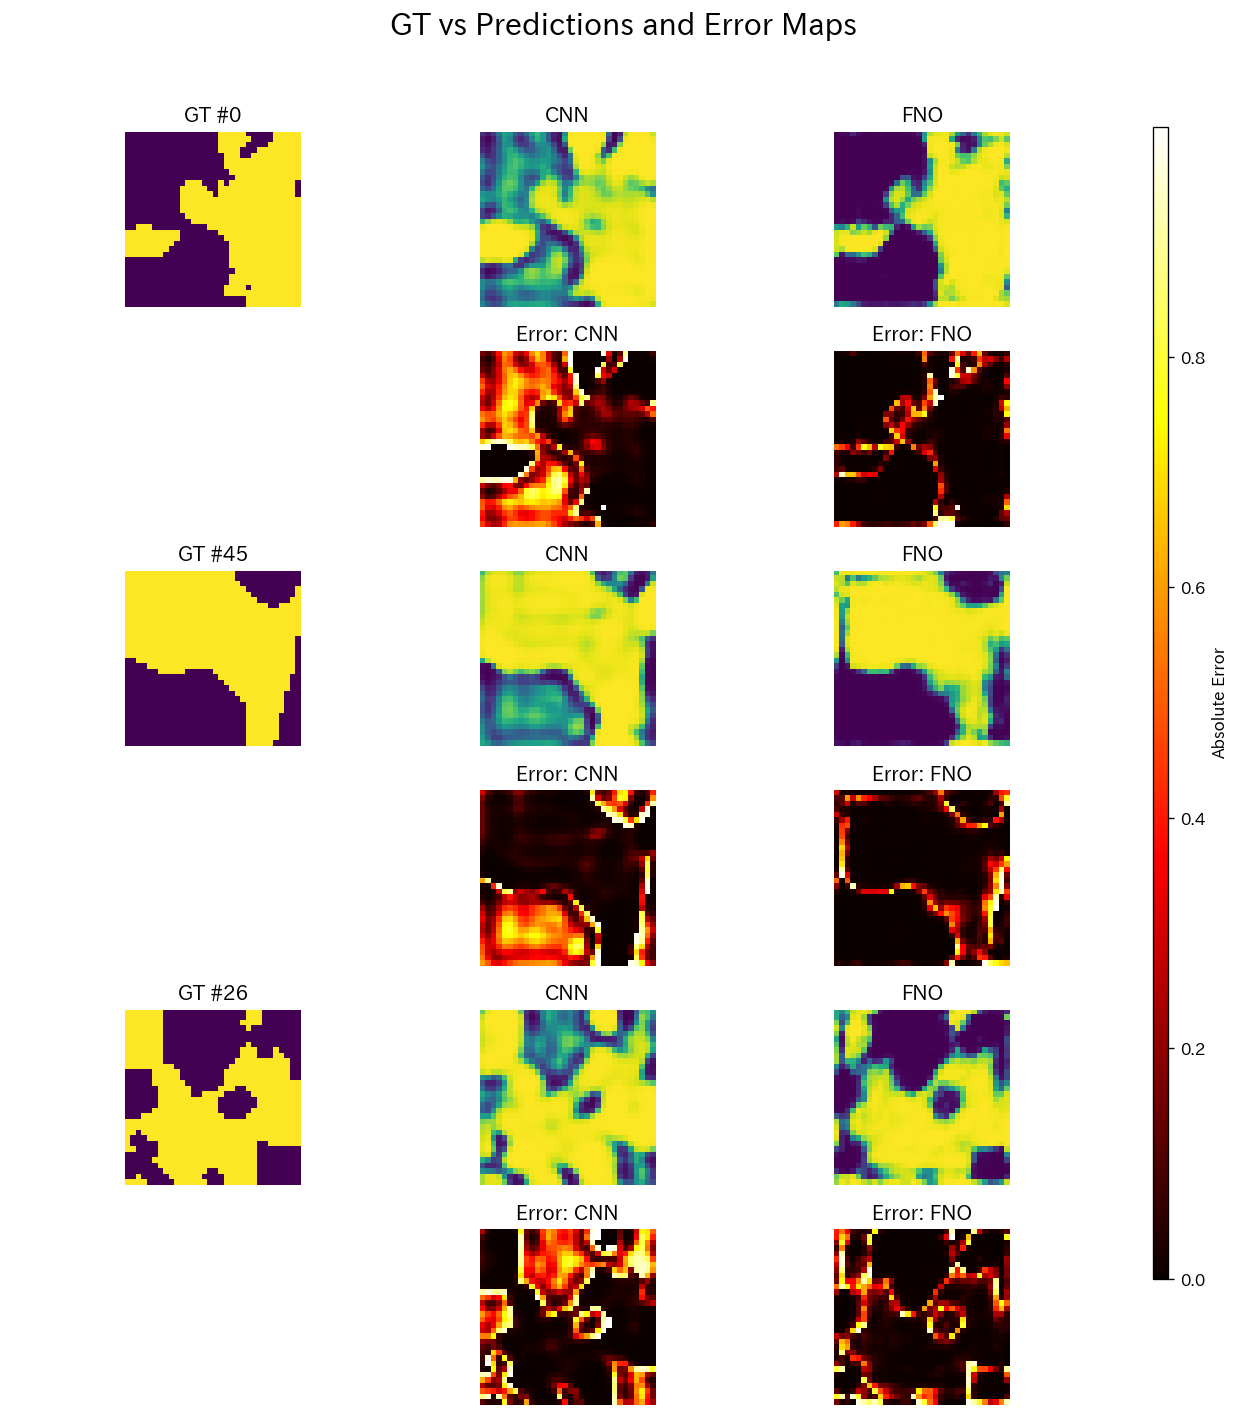

FP: 12544, FN: 189


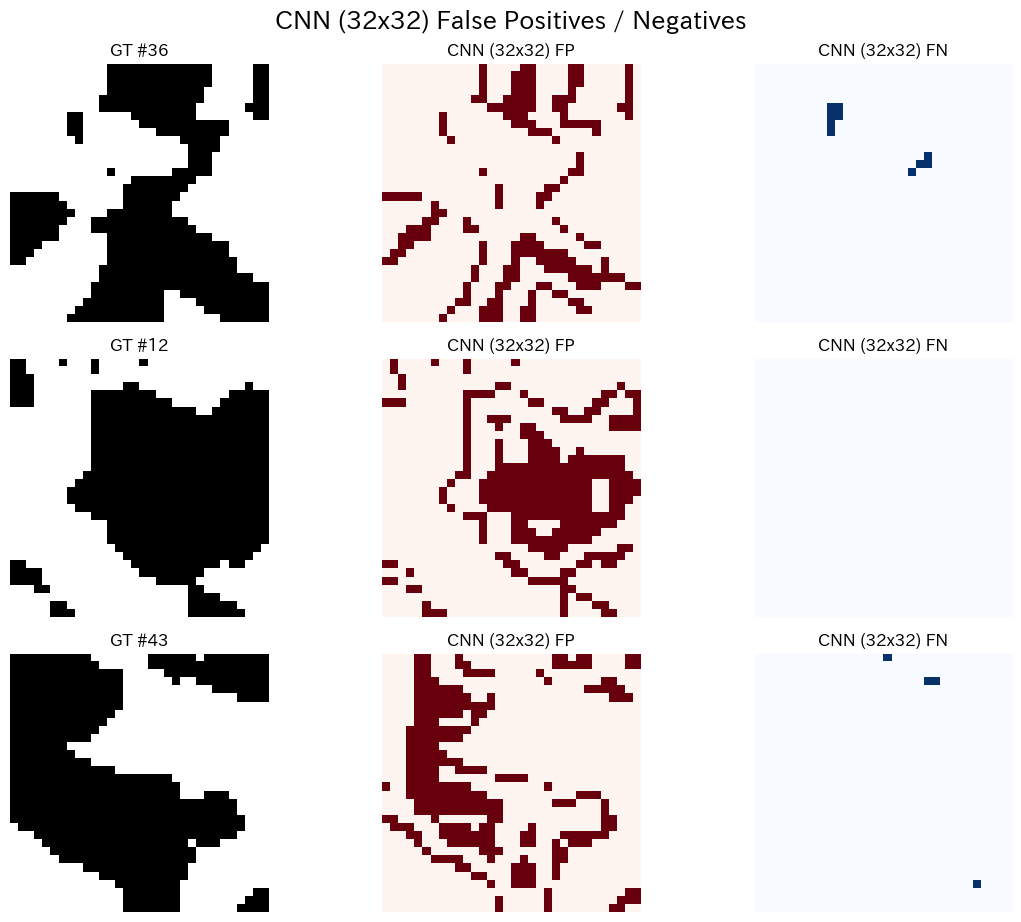

FP: 2280, FN: 1642


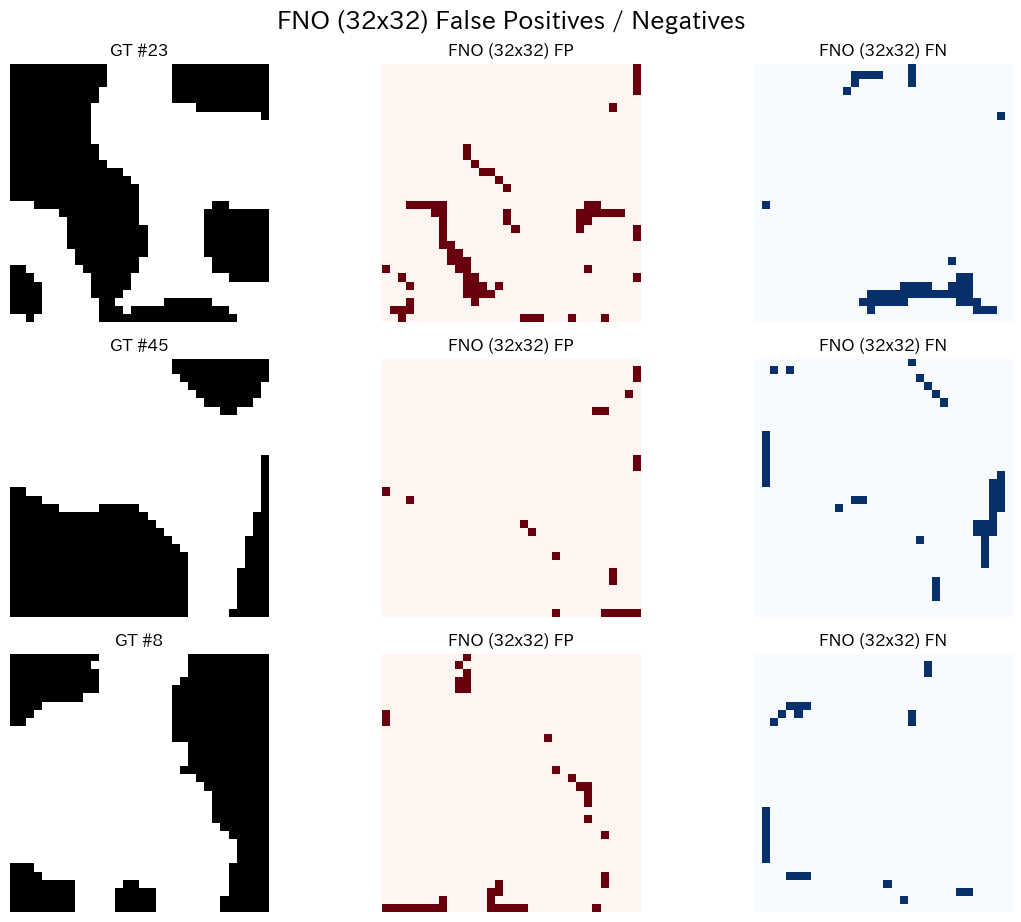

In [11]:
plot_prediction_and_error_maps(gt_images_32, preds_32,labels_32, num_samples=3)

plot_fp_fn_examples(pred_cnn_32, y_test_32.cpu(), model_name="CNN (32x32)", num_samples=3)
plot_fp_fn_examples(pred_fno_32, y_test_32.cpu(), model_name="FNO (32x32)", num_samples=3)

